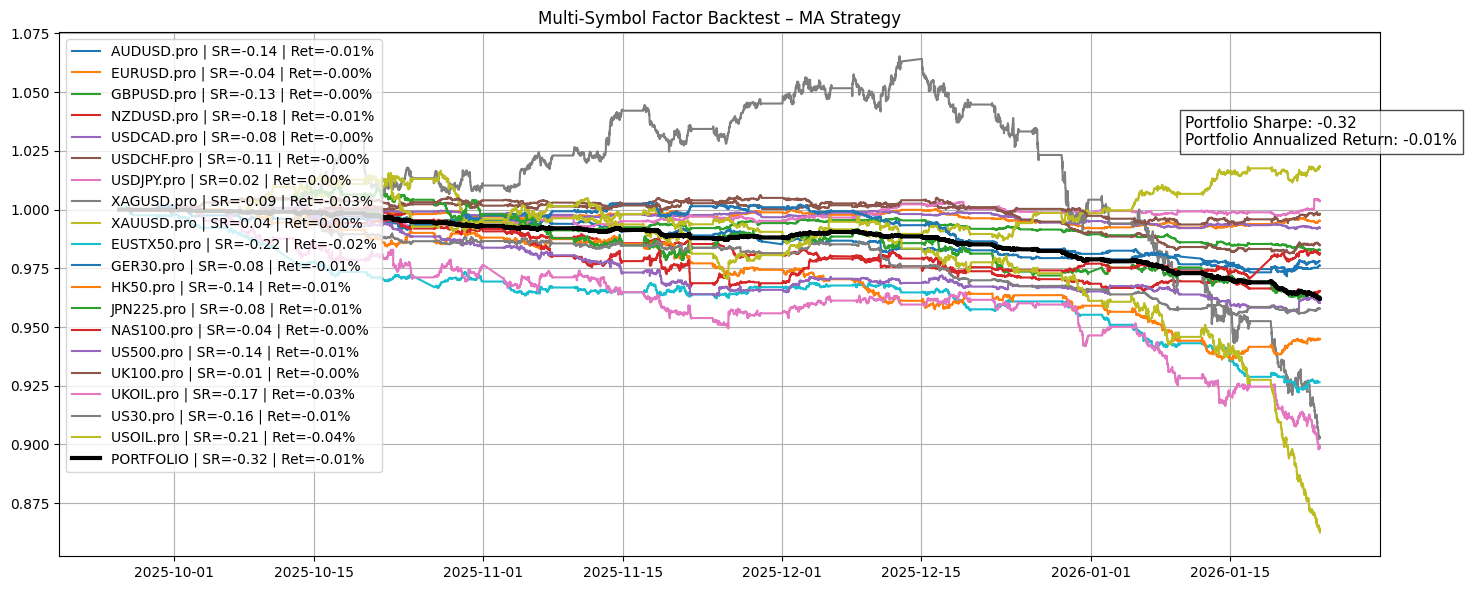

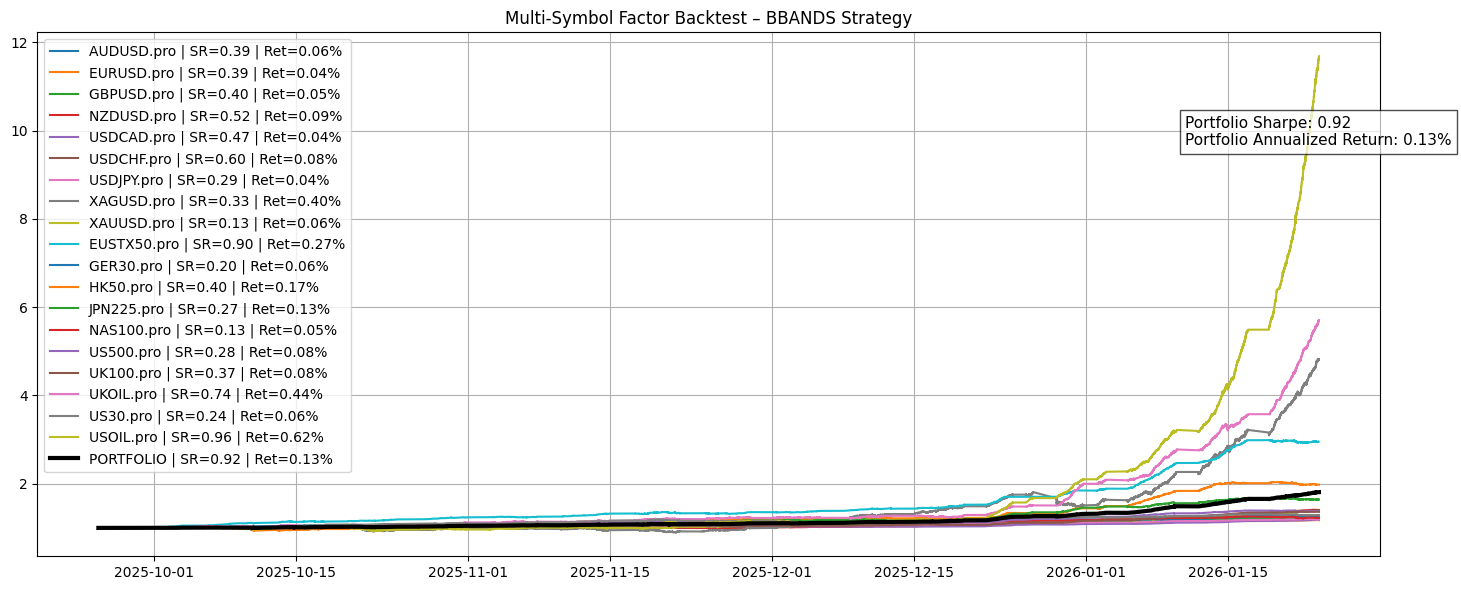

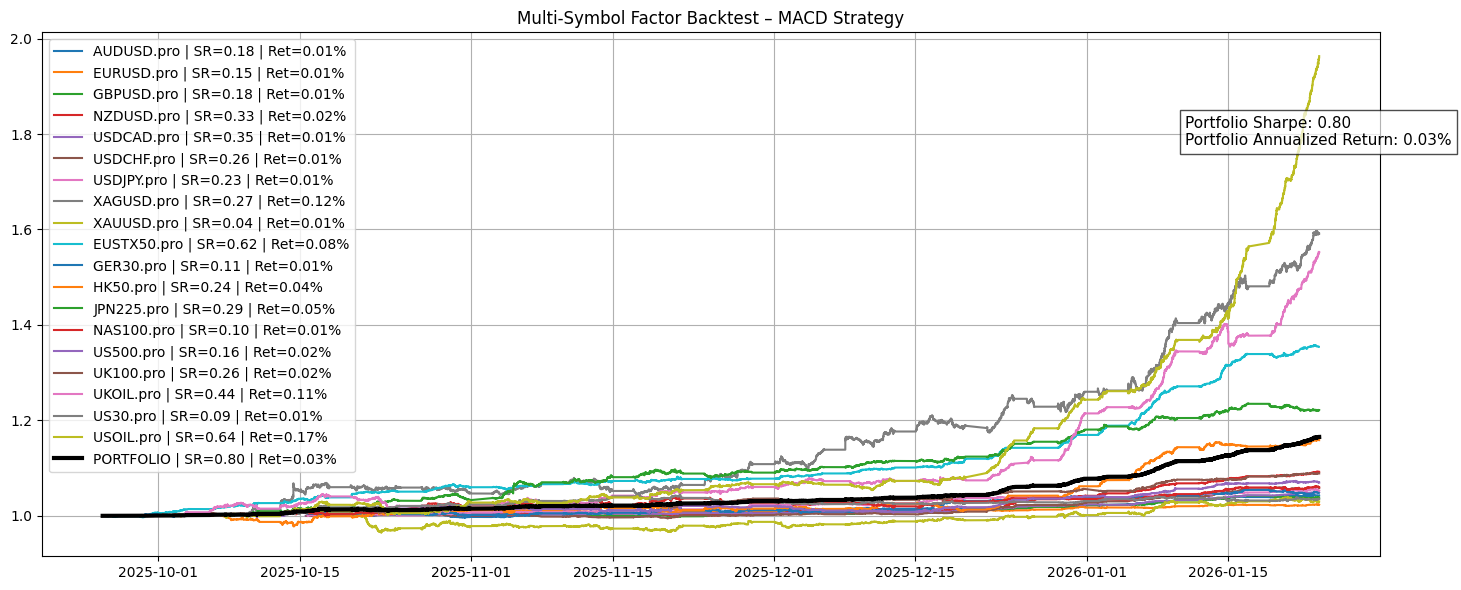

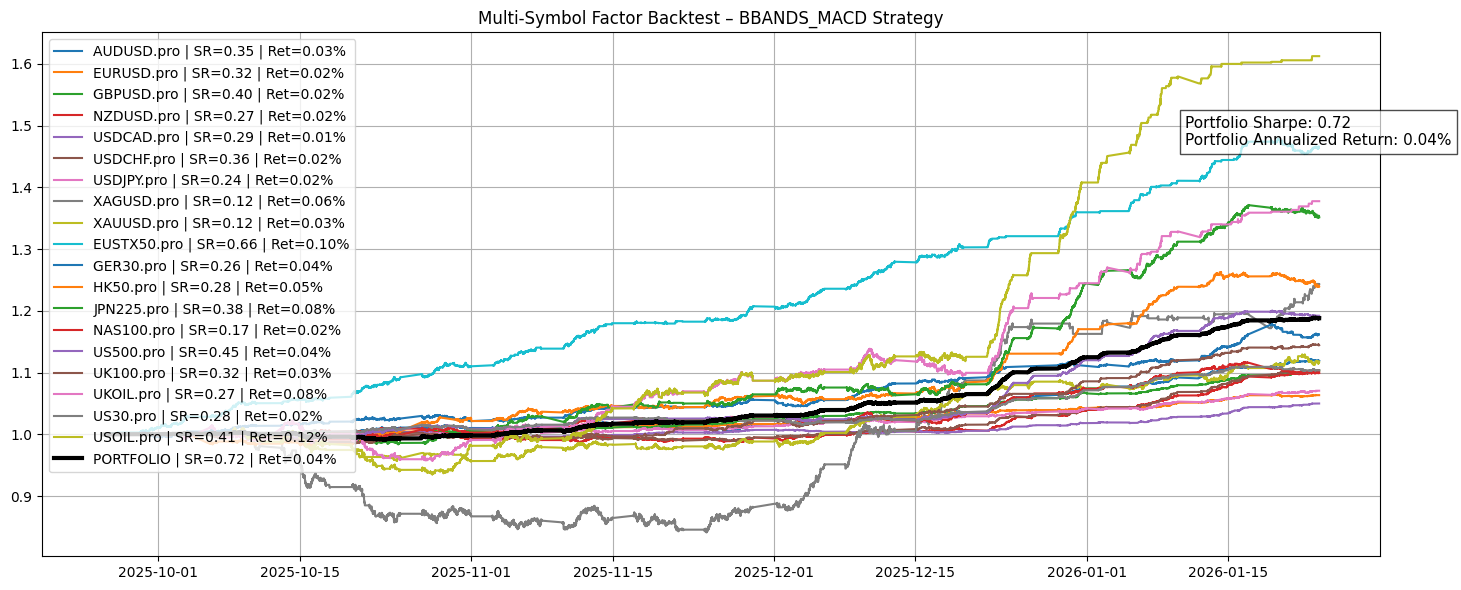

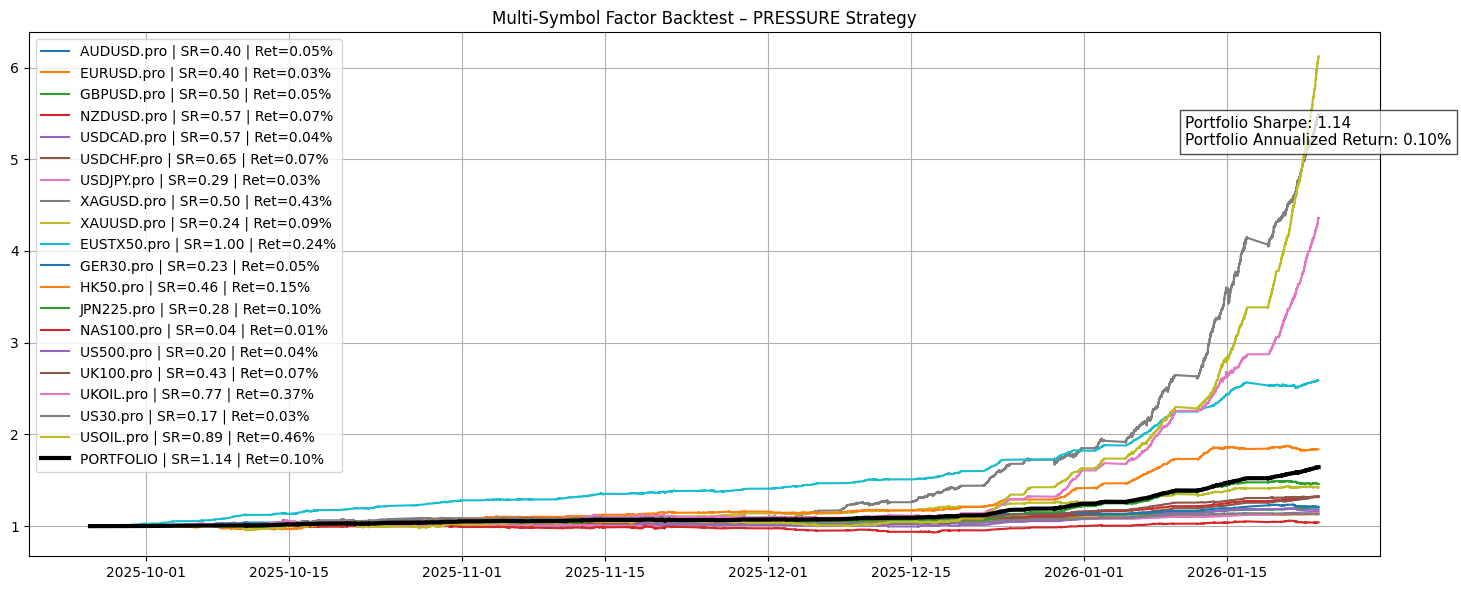

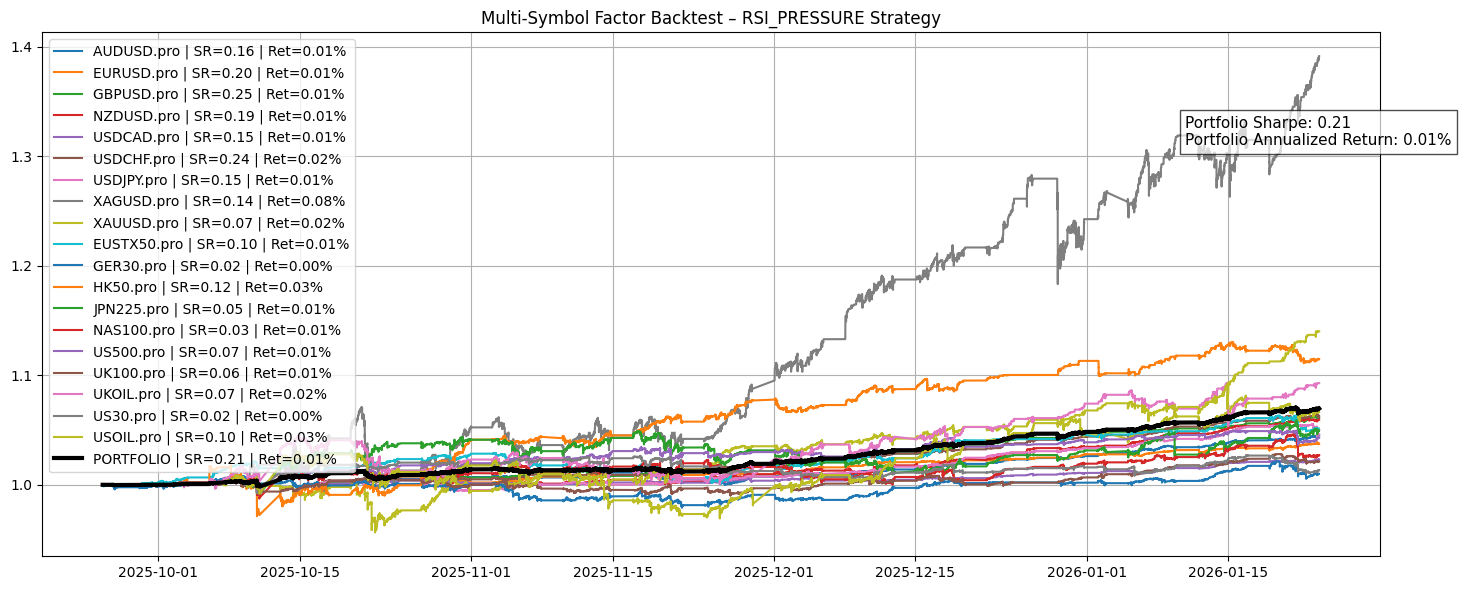

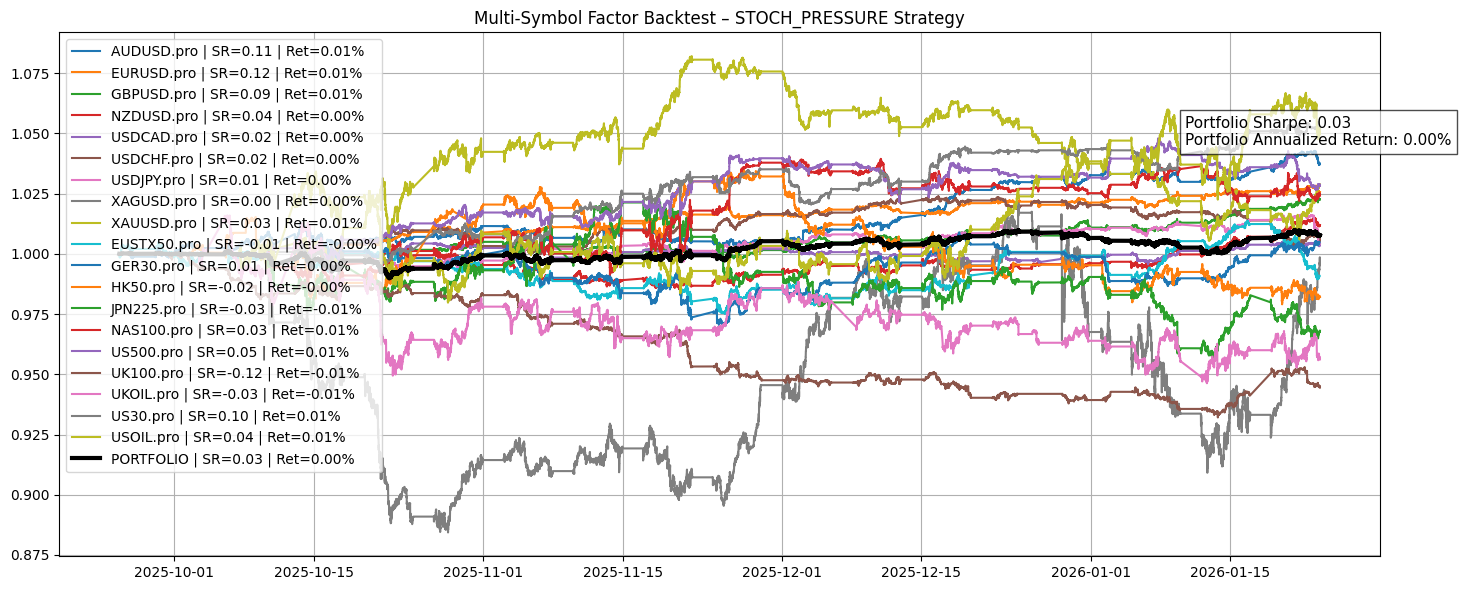

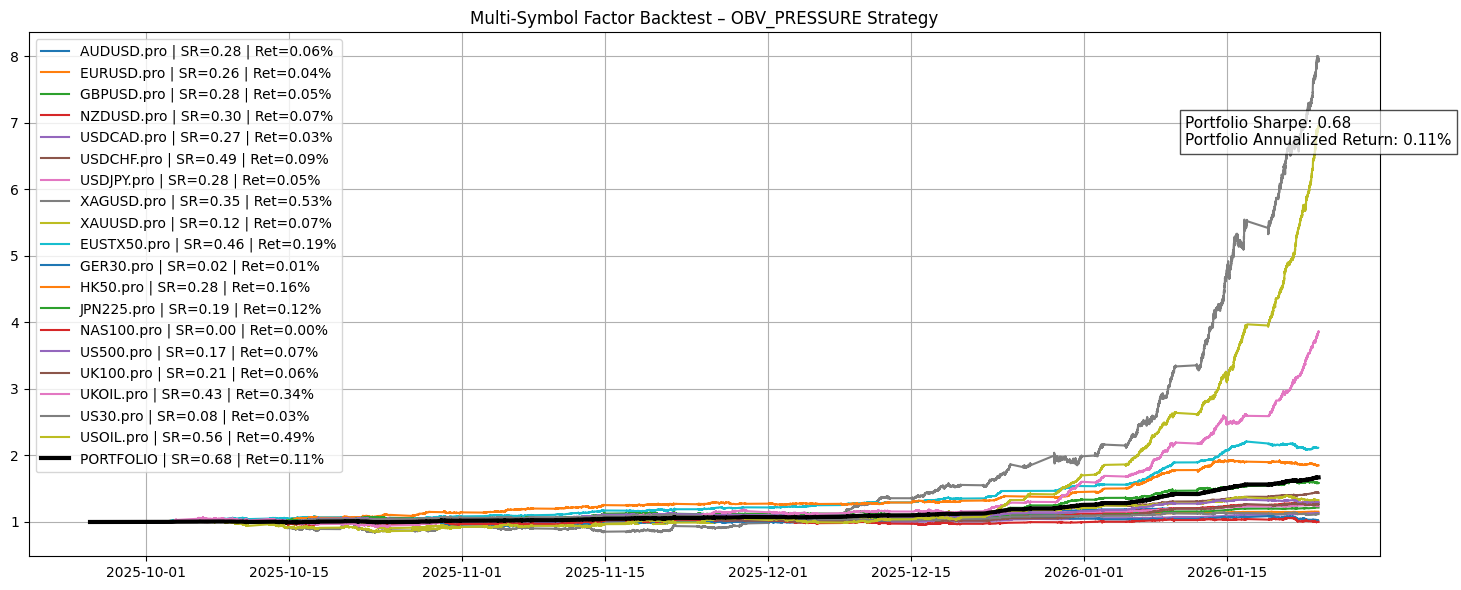

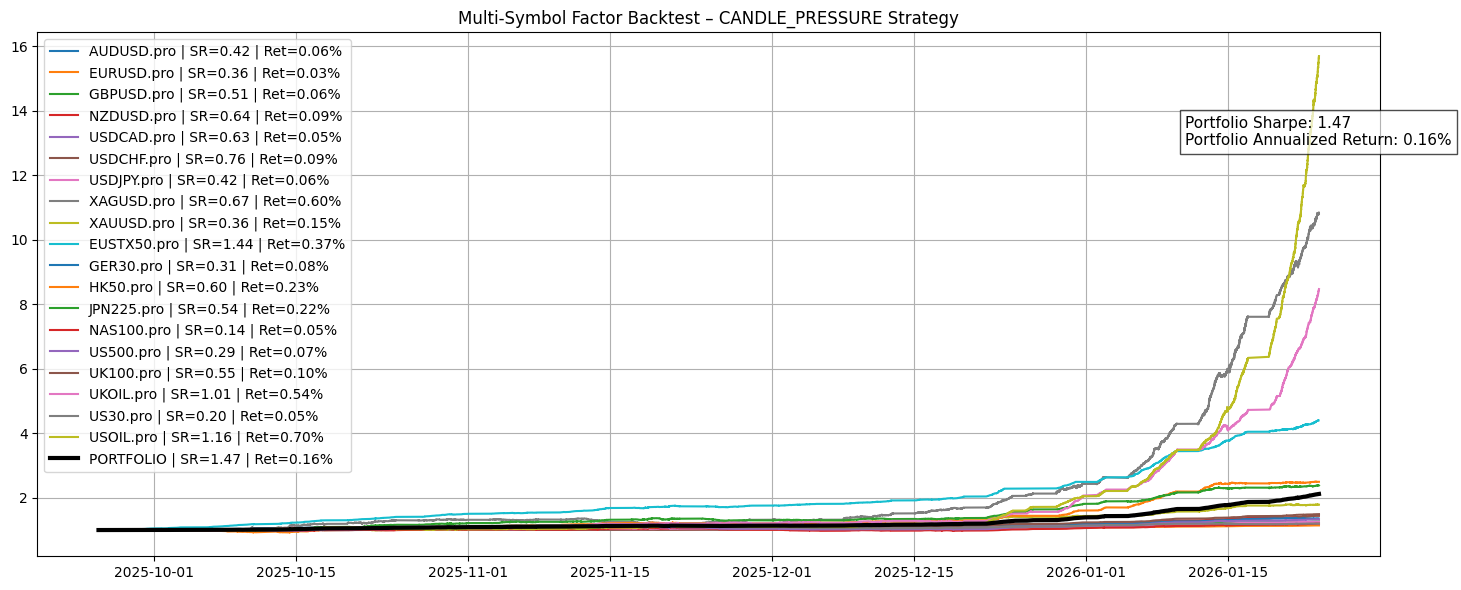

In [1]:
import MetaTrader5 as mt5
import pandas as pd
from backtest import backtest_symbols
from brokers import get_broker

broker = get_broker("acg")
broker.initialize()



factors = [
    "ma",
    "bbands",
    "macd",
    "bbands_macd",
    "pressure",          # MFI + AD imbalance
    "rsi_pressure",      # RSI reversal imbalance
    "stoch_pressure",    # Stochastic momentum imbalance
    "obv_pressure",      # OBV slope pressure
    "candle_pressure"    # Candle body dominance
]

symbols = pd.read_csv("acg_macro_signal.csv", header=None, sep="\t")[0].tolist()

all_perfs = []   # store only the performance part
timeframe = mt5.TIMEFRAME_M1
for factor in factors:
    perf, _ = backtest_symbols(
        symbols,
        factor=factor,
        timeframe=timeframe
    )
    
    perf["Factor"] = factor.upper()   # tag it
    all_perfs.append(perf)

In [2]:
import numpy as np
# 1. Combine all performance tables
combined = pd.concat(all_perfs, ignore_index=True)

# 2. Absolute Sharpe
combined["AbsSharpe"] = combined["Sharpe"].abs()

# 3. Select best strategy per symbol (keeps Returns series)
best_per_symbol = combined.loc[
    combined.groupby("Symbol")["AbsSharpe"].idxmax()
].reset_index(drop=True)

print("Best strategy per symbol:")
print(best_per_symbol[["Symbol", "Sharpe", "Factor"]])

# ---------------------------------------------------------
# Build portfolio from selected strategies
# ---------------------------------------------------------

# Extract return series
ret_dict = {
    row["Symbol"]: row["Returns"]
    for _, row in best_per_symbol.iterrows()
}

# Combine into DataFrame
portfolio_df = pd.DataFrame(ret_dict).fillna(0)

# Equal-weight portfolio return
portfolio_ret = portfolio_df.mean(axis=1)

# Portfolio Sharpe
portfolio_sharpe = (
    portfolio_ret.mean() / portfolio_ret.std()
) * np.sqrt(252)

print(f"\nPortfolio Sharpe (best-strategy filter): {portfolio_sharpe:.3f}")

Best strategy per symbol:
         Symbol    Sharpe           Factor
0    AUDUSD.pro  0.417335  CANDLE_PRESSURE
1    EURUSD.pro  0.397555         PRESSURE
2   EUSTX50.pro  1.437557  CANDLE_PRESSURE
3    GBPUSD.pro  0.508004  CANDLE_PRESSURE
4     GER30.pro  0.312800  CANDLE_PRESSURE
5      HK50.pro  0.599133  CANDLE_PRESSURE
6    JPN225.pro  0.543058  CANDLE_PRESSURE
7    NAS100.pro  0.169504      BBANDS_MACD
8    NZDUSD.pro  0.641706  CANDLE_PRESSURE
9     UK100.pro  0.546889  CANDLE_PRESSURE
10    UKOIL.pro  1.014406  CANDLE_PRESSURE
11     US30.pro  0.283980      BBANDS_MACD
12    US500.pro  0.445501      BBANDS_MACD
13   USDCAD.pro  0.629287  CANDLE_PRESSURE
14   USDCHF.pro  0.757073  CANDLE_PRESSURE
15   USDJPY.pro  0.422914  CANDLE_PRESSURE
16    USOIL.pro  1.164547  CANDLE_PRESSURE
17   XAGUSD.pro  0.665042  CANDLE_PRESSURE
18   XAUUSD.pro  0.360356  CANDLE_PRESSURE

Portfolio Sharpe (best-strategy filter): 1.647


In [3]:
import MetaTrader5 as mt5
import pandas as pd 
from factorsignal import generate_signal
from backtest import fetch_mt5_data


symbols = pd.read_csv("acg_macro_signal.csv", header=None, sep="\t")[0].tolist()

df = fetch_mt5_data(symbol=symbols[1], timeframe=mt5.TIMEFRAME_M1)[0]
signal = generate_signal(df, factor=factor)

sig_prev = signal.shift(1)
steps = (signal - sig_prev).abs().fillna(0).astype(int)

counts = steps.value_counts().sort_index()
print(counts)
no_transition = (steps == 0).sum()
one_step      = (steps == 1).sum()
two_steps     = (steps == 2).sum()

print("No transition:", no_transition)
print("1-step transitions:", one_step)
print("2-step transitions:", two_steps)

0    39648
1    49558
2    10793
Name: count, dtype: int64
No transition: 39648
1-step transitions: 49558
2-step transitions: 10793
